# The Sheer Joy of Accelerating Your Existing Python Code with Numba! Part II : Numba for CUDA GPUs

There are two basic approaches to GPU programming in Numba:
- ufuns/gufuncs
- CUDA Python Kernels

**NOTE:**
- GPUs are designed for **data parallelism**
- Maximum throughput is achieved when you are computing the same operations on many elements at once

## Universal Functions (ufuns/gufuncs)

- Universal functions are naturally data parallel.
- NumPy has the concept of universal functions, which are functions that can take NumPy arrays of varrying dimensions(or scalars) and operate on them element by element

In [1]:
import numpy as np

In [2]:
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

In [3]:
np.add(a, b)

array([11, 22, 33, 44])

- Ufuncs also can combine scalars with arrays:
    

In [4]:
np.add(a, 10)

array([11, 12, 13, 14])

- Arrays of different, but compatible dimensions can also be combined. The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array

In [5]:
c = np.arange(16).reshape((4, 4))
c

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [6]:
np.add(b, c)

array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

- If we want to add b to each column, we need to transpose it first. One way to do this is by inserting a new axis

In [7]:
b_t = b[:, np.newaxis]
b_t

array([[10],
       [20],
       [30],
       [40]])

In [8]:
np.add(b_t, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

If `Ufuncs` interest you, the NumPy documentation has a much more discussion of ufuncs:
    https://docs.scipy.org/doc/numpy/reference/ufuncs.html

### Making ufuncs for the GPU

- Numba has the ability to create compiled ufuncs:
    - You implement a scalar function of all the inputs
    - Numba will figure out the broadcast rules for you
- ufuncs that use CUDA requires giving an explicit type signature and setting the `target` attribute

In [9]:
from numba import cuda

In [10]:
cuda.select_device(0)

<weakproxy at 0x7faeb7c7e4a8 to Device at 0x7faeb9f53c50>

In [11]:
from numba import vectorize

In [12]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [13]:
add_ufunc(a, b)

array([11, 22, 33, 44])

In [14]:
add_ufunc(b_t, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

A lot of things just happened! Numba automatically:

- Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
- Allocated GPU memory for the inputs and the output.
- Copied the input data to the GPU.
- Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
- Copied the result back from the GPU to the CPU.
- Returned the result as a NumPy array on the host.

**This is very convenient for testing, but copying data back and forth between the CPU and GPU can be slow and hurt performance.** 

In [15]:
np_cpu = %timeit -o np.add(b_t, c)  # NumPy on CPU

1.62 µs ± 233 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [16]:
numba_gpu = %timeit -o add_ufunc(b_t, c) # Numba on GPU

1.7 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
numba_gpu.best / np_cpu.best 

803.0991299567952

**The GPU is a lot slower than the CPU???**

This is to be expected because we have (deliberately) misused the GPU in several ways in this example:

- **Our inputs are too small:** the GPU achieves performance through parallelism, operating on thousands of values at once. Our test inputs have only 4 and 16 integers, respectively. We need a much larger array to even keep the GPU busy.
- **Our calculation is too simple:** Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU. If our calculation does not involve enough math operations (often called "arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
- **We copy the data to and from the GPU:** While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence. In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
- **Our data types are larger than necessary:** Our example uses int64 when we probably don't need it. Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU. Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats. NumPy defaults to 64-bit data types when creating arrays, so it is important to set the dtype attribute or use the ndarray.astype() method to pick 32-bit types when you need them.


Let's try an example that is faster on the GPU

In [18]:
import math

In [19]:
# Define CPU ufunc
@vectorize(['float32(float32, float32)',])
def trig_func_cpu(x, y):
    return ((math.sin(x) ** 2) + (math.cos(y) ** 2))

In [20]:
a = np.random.random((1000, 1000)).astype('float32')
b = np.random.random((1000, 1000)).astype('float32')

In [21]:
np_cpu = %timeit -o trig_func_cpu(a, b)

23 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
# Define GPU ufunc 
@vectorize(['float32(float32, float32)'], target='cuda')
def trig_func_gpu(x, y):
    return ((math.sin(x) ** 2) + (math.cos(y) ** 2))

In [23]:
numba_gpu = %timeit -o trig_func_gpu(a, b)

13.7 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
np_cpu.best / numba_gpu.best

1.4624081453456907

That's a pretty large improvement, even including the overhead of copying all the data to and from the GPU. Ufuncs that use special functions (exp, sin, cos, etc) on large data sets run especially well on the GPU.

### CUDA Device Functions

Ufuncs are great, but you should not have to cram all of your logic into a single function body. You can also create normal functions that are only called from other functions running on the GPU. (These are similar to CUDA C functions defined with `__device__`.)

Device functions are created with the `numba.cuda.jit` decorator. 

To illustrate this, Let's build a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. Let's make some sample data:

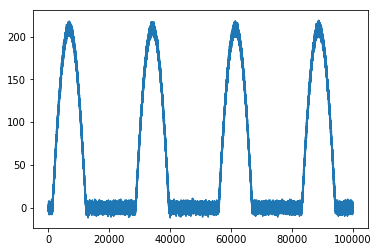

In [25]:
# A noisy pulse train
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

In [26]:
from numba import cuda

@cuda.jit(device=True)
def _validate_input(waveform_value, threshold):
    if waveform_value < threshold:
        return 0
    else:
        return waveform_value

@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    return _validate_input(waveform_value, threshold)

Note that the CUDA compiler aggressively inlines device functions, so there is generally no overhead for function calls. Similarly, the "int" returned by `_validate_input()` is not actually created as a Python object, but represented temporarily as a struct, which is then optimized away by the compiler.

In [27]:
suppressed_waveform = zero_suppress(waveform, 15.0)

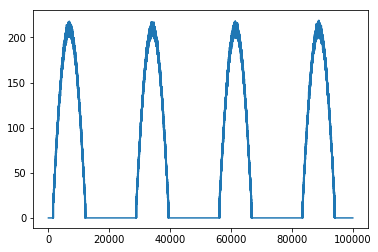

In [28]:
plt.plot(suppressed_waveform)

## Managing GPU Memory

- During previous examples, we used NumPy arrays on the CPU as inputs and outputs. If you want to reduce the impact of host-to-device/device-to-host bandwidth, it is best to copy data to the GPU explicitly and leave it there to amortize the cost over multiple function calls. 

- In addition, allocating device memory can be relatively slow, so allocating GPU arrays once and refilling them with data from the host can also be a performance improvement.



In [29]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [30]:
n = 1000

In [31]:
x = np.random.random((n, n)).astype('float32')
y = np.random.random((n, n)).astype('float32')

In [32]:
baseline = %timeit -o add_ufunc(x, y)

13.9 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


The `numba.cuda` module includes a function that will copy host data to the GPU and return a CUDA device array:

In [33]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

In [34]:
x_device, x_device.shape, x_device.dtype

(<numba.cuda.cudadrv.devicearray.DeviceNDArray at 0x7faeb49a4940>,
 (1000, 1000),
 dtype('float32'))

Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [35]:
cuda_array_improv = %timeit -o add_ufunc(x_device, y_device)

2.36 ms ± 432 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
baseline.best / cuda_array_improv.best

6.35935993136422

That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host. We can create the output buffer with the `numba.cuda.device_array()` function:

In [37]:
out_device = cuda.device_array(shape=(n, n), dtype=np.float32)  # does not initialize the contents, like np.empty()

And then we can use a special out keyword argument to the ufunc to specify the output buffer:

In [38]:
cuda_output_buffer_improv = %timeit -o add_ufunc(x_device, y_device, out=out_device)

1.41 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
cuda_array_improv.best / cuda_output_buffer_improv.best

1.5948925597445118

Now that we have removed the device allocation and copy steps, the computation runs much faster than before. When we want to bring the device array back to the host memory, we can use the `copy_to_host()` method:

In [40]:
out_host = out_device.copy_to_host()
out_host[:5]

array([[1.1170301 , 0.976838  , 0.79459506, ..., 0.9236014 , 0.9341868 ,
        1.0936621 ],
       [1.1006578 , 0.14928854, 0.4562398 , ..., 0.29398024, 0.32563463,
        1.7855898 ],
       [0.3565393 , 1.3518932 , 1.0091645 , ..., 0.48668748, 1.0067339 ,
        1.4361947 ],
       [1.7744043 , 0.78218246, 1.0507063 , ..., 0.32696122, 0.33663163,
        0.49128422],
       [1.0083491 , 0.93564826, 0.2649076 , ..., 1.5481386 , 1.5669737 ,
        0.65463626]], dtype=float32)

## CUDA Kernels 

Ufuncs (and generalized ufuncs) are the easiest way in Numba to use the GPU, and present an abstraction that requires minimal understanding of the CUDA programming model. However, not all functions can be written as ufuncs. Many problems require greater flexibility, in which case you want to write a CUDA kernel

Fully explaining the CUDA programming model is beyond the scope of this notebook. It's highly recommended that everyone writing CUDA kernels with Numba take the time to read Chapters 1 and 2 of the CUDA C Programming Guide:

- Introduction: http://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#introduction
- Programming Model: http://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#programming-model

The programming model chapter gets a little in to C specifics, but familiarity with CUDA C can help write better CUDA kernels in Python.

- **Numba Documentation**: http://numba.pydata.org/

In [41]:
%load_ext watermark

In [42]:
%watermark -u -n -t -iv -g -m

numpy      1.16.1
numba      0.41.0
json       2.0.9
matplotlib 3.0.2
last updated: Sun Feb 03 2019 14:54:44 

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : f47596503b64cfdae6ef3580145ddeb98fde8516
